In [1]:
import random

from utils import image_processing as img_pr
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Disease detection model
This example intends to show the process that evolves on training a model dor disease detection.
the notebook is divided as follows:
* Organize score datasets
* merge scores with the extracted images
* save images into folders, one per each category
* Train a vgg model
* Test the model.

In [2]:
def find_list_pairs(list1, list2):
    list_pairs = []
    for i in np.unique(list1):
        for j in np.unique(list2):
            if i in j:
                list_pairs.append((j, i))

    return list_pairs

def get_score_table(year, scorestable, images_path):

    year_subset = scorestable.loc[scorestable.year == year]
    if year == 2018:
        idimages =year_subset.id_image
    else:
        idimages = [i.split("/")[-1] for i in
               year_subset.path if i is not np.nan]
    year_subset = year_subset[year_subset['path'].notnull()]
    year_subset.insert(
        year_subset.shape[1],
        'id_images',
        idimages)

    ids_df = pd.DataFrame(
                    find_list_pairs(year_subset.id_images,
                    images_path))

    ids_df.columns = ["path", "id_images"]

    ids_df = ids_df.merge(year_subset[['id_images', 'score']],
                                  on='id_images',  how='left')
    ids_df['year'] = year
    return ids_df

#### Read and organice scores data

In [122]:
# set images path
folder_path = 'input_score'
input_folder = os.path.join("images", folder_path, "")
imgs_data = []
imgs_data = img_pr.ImageData(input_folder,
                             pattern="jpg")

score_table = pd.read_excel("disease_score/summary_.xlsx")
score_table.head()

In [124]:
## set up score table
ids2017 = get_score_table(2017,
                               score_table,
                               imgs_data._path_files)

ids2018 = get_score_table(2018,
                               score_table,
                               imgs_data._path_files)

ids2019 = get_score_table(2019,
                               score_table,
                               imgs_data._path_files)

ids2019 = ids2019.drop_duplicates('path')

df_summary = pd.concat([ids2017,ids2018,  ids2019])

<AxesSubplot:>

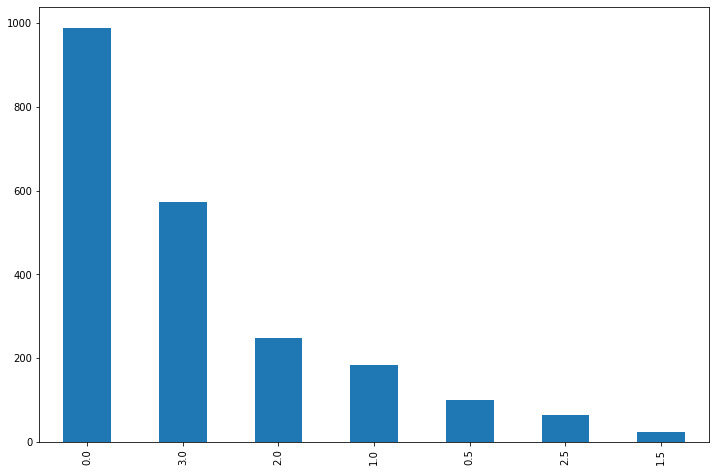

In [126]:
%matplotlib inline
FIG_SIZE = (12,8)
df_summary['score'].value_counts().plot(kind='bar',
                                         figsize=FIG_SIZE)

<AxesSubplot:>

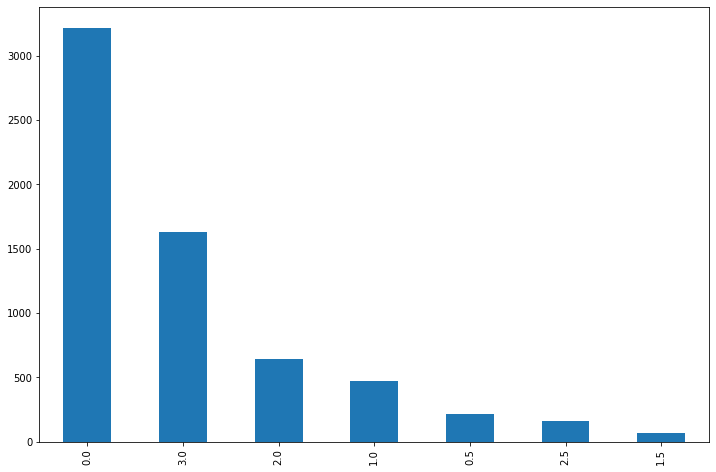

In [71]:
%matplotlib inline
FIG_SIZE = (12,8)
score_table['score'].value_counts().plot(kind='bar',
                                         figsize=FIG_SIZE)

#### Imbalanced data

we face an imbalanced dataset, there are more registers for a specific score. So, we selected a maximun number of
registers based on the number of observation for the lowest registers.

In [127]:
#
df_summary_f = df_summary.loc[df_summary.score.isin([1.,2.,3.,0])]
namount =df_summary_f.groupby('score'
                         )['score'].count()
print(namount)
min_values = np.array(namount).min()

score
0.0    989
1.0    183
2.0    247
3.0    572
Name: score, dtype: int64


In [128]:
model_img_paths = []

for i in np.unique(df_summary_f.score):
    subsetd = df_summary_f.loc[
        df_summary_f.score == i]
    mlist = list(range(subsetd.shape[0]))
    random.seed(123)
    random.shuffle(mlist)
    limit_n = min_values+20
    if limit_n>subsetd.shape[0]:
        limit_n = min_values

    mlist = np.array(mlist)[0:limit_n]

    model_img_paths.append(subsetd.iloc[mlist][
                                   ['path', 'score']])

model_img_paths = pd.concat(model_img_paths)

#### merge with no cabbage

In [129]:
folder_path = 'non_cabbage'
input_folder = os.path.join("images", folder_path, "")

imgs_noncabbage = img_pr.ImageData(input_folder,
                             pattern="jpg")

In [130]:
path_non = pd.DataFrame({'path': imgs_noncabbage._path_files,
              'score': [4.0 for i in range(len(
                  imgs_noncabbage._path_files))]})

model_img_paths = pd.concat([model_img_paths, path_non])
model_img_paths.shape

(998, 2)

#### export images as training and validation data sets

In [140]:
val_percentage = 20
split_tr_val = []
for i in np.unique(model_img_paths.score):
    subsetd = model_img_paths.loc[
        model_img_paths.score == i]
    print(subsetd.shape[0])
    mlist = list(range(subsetd.shape[0]))
    random.seed(123)
    random.shuffle(mlist)

    limit_n = int(subsetd.shape[0] *
                  (val_percentage/100))

    training_list = np.array(mlist)[:(subsetd.shape[0]-limit_n)]
    val_list = np.array(mlist)[(subsetd.shape[0]-limit_n):]

    split_tr_val.append(
        [subsetd.iloc[training_list],
         subsetd.iloc[val_list]]
    )

203
183
203
203
206


In [142]:
split_tr_val[0][1]



,path,score
197,images\input_score\y2017_4482_1_161A9114.JPG,0.0
496,images\input_score\y2019_awaji_200205_07_3503_...,0.0
414,images\input_score\y2019_awaji_200205_07_1722_...,0.0
1785,images\input_score\y2019_katsuura_40710_1_4N6A...,0.0
834,images\input_score\y2019_awaji_200205_07_11716...,0.0
648,images\input_score\y2019_awaji_200205_07_6704_...,0.0
110,images\input_score\y2019_awaji_200226_3504畝1列_...,0.0
768,images\input_score\y2019_awaji_200205_07_10065...,0.0
1693,images\input_score\y2019_katsuura_11307_1_4N6A...,0.0
1904,images\input_score\y2019_katsuura_18412_2_4N6A...,0.0
